In [1]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

import os
os.chdir('..')

from cvae.cvae import ConditionalVAE
from envs.panda_center_out import PandaCenterOutEnv

In [2]:
with open('data/demonstration_center_out.pkl', 'rb') as fp:
    episodes = pickle.load(fp)

In [3]:
env = PandaCenterOutEnv(render=False, control_type='ee')

# Enumerate the goals

goals = set()

while len(goals) != 8:
    obs = env.reset()
    goals.add(tuple(obs['desired_goal']))
    
goals = sorted(list(goals), key=lambda g: (-g[1], g[0]))

neutral_ee_position = obs['achieved_goal']
neutral_joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])

# Enumerate the joint angles for each goal

joint_angles_at_goals = []

for goal in goals:
    while tuple(env._get_obs()['desired_goal']) != goal:
        obs = env.reset()
    
    is_success = False
    while not is_success:
        a = obs['desired_goal'] - obs['achieved_goal']
        obs, _, _, info = env.step(a)
        is_success = info['is_success']
        
    joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])
    joint_angles_at_goals.append(joint_angles)

In [4]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])

In [5]:
env = PandaCenterOutEnv(render=False, control_type='joints')

In [6]:
def visualize_encoder(decoder):
    actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi]) 
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    std_x = std.copy()
    std_x[:, 1] = 0
    std_y = std.copy()
    std_y[:, 0] = 0

    horizontal_lines = list(zip(mu-std_x, mu+std_x))
    vertical_lines = list(zip(mu-std_y, mu+std_y))

    hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
    vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_collection(hlc)
    ax.add_collection(vlc)
    ax.autoscale()
    ax.margins(0.1)
    ax.scatter(mu[:, 0], mu[:, 1])
    ax.set_title('mean and variance of encoder')
    
    plt.show()

In [7]:
def get_latent_bounds(decoder):
    actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi]) 
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    return {
        'x_min': min((mu - std)[:, 0]), 
        'x_max': max((mu + std)[:, 0]), 
        'y_min': min((mu - std)[:, 1]), 
        'y_max': max((mu + std)[:, 1])}

In [8]:
def visualize_decoder(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

    fig, axs = plt.subplots(3, 3, figsize=(20, 7))

    for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
        if i >= 4:
            i += 1 # offset for visualization

        contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:7])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
        axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
        axs[i // 3, i % 3].set_title(goal[:2])

    contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    if subtract_neutral_from_context:
        contexts -= torch.tensor(neutral_joint_angles[:7])
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))

In [9]:
def visualize_decoder_forward_kinematics(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
        if i >= 4:
            i += 1 # offset for visualization

        contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:7])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()

        actions_ee = []
        env.robot.set_joint_angles(joint_angles)
        current_ee_position = env._get_obs()['achieved_goal']

        for action_joints in actions_joints:
            obs, _, _, _ = env.step(action_joints)
            actions_ee.append(obs['achieved_goal'] - current_ee_position)
            env.robot.set_joint_angles(joint_angles)

        actions_ee = np.array(actions_ee)
        axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
        axs[i // 3, i % 3].set_title(goal[:2])

    actions_ee = []
    env.reset()

    contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    if subtract_neutral_from_context:
        contexts -= torch.tensor(neutral_joint_angles[:7])
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()

    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
        env.reset()

    actions_ee = np.array(actions_ee)
    axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    
    plt.show()

In [10]:
def offline_evaluation(decoder, subtract_neutral_from_context = False):
    fig = plt.figure(figsize=(10, 10))

    for episode in episodes[:30]:
        ee_positions_ground_truth = np.array(
            [step['previous_observation']['achieved_goal'] for step in episode])
        plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')

        obs = env.reset()

        ee_positions_predicted = []
        for step in episode:
            context = torch.tensor(step['previous_joint_angles'], dtype=torch.float)
            if subtract_neutral_from_context:
                context -= torch.tensor(neutral_joint_angles[:7])
            z = decoder.encoder(
                torch.cat((
                    torch.tensor(step['action_joints'], dtype=torch.float), 
                    context))).reshape(1, -1)
            z = decoder.fc_mu(z)
            joint_action = decoder(
                latent=z, 
                context=context.reshape(1, -1))
            obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
            ee_positions_predicted.append(obs['achieved_goal'])

        ee_positions_predicted = np.array(ee_positions_predicted)
        plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')

    plt.show()

## whole-elevator-412
KL = 1 annealed

Here, posterior collapse happens and we can observe the decoder at 9 different positions depend solely on context.

In [11]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/9lz2c49j/checkpoints/epoch=399-step=1000399.ckpt')

In [12]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

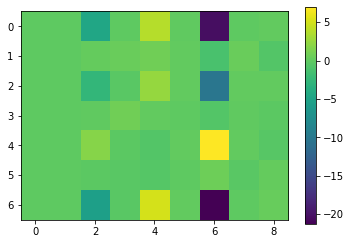

In [13]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

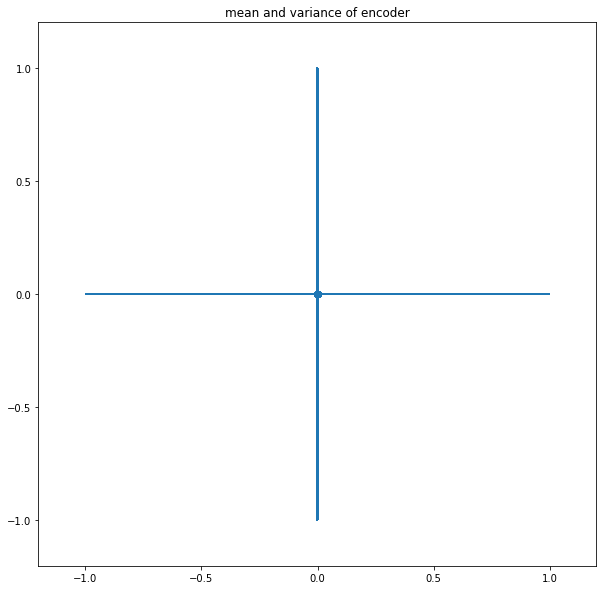

In [14]:
visualize_encoder(decoder)

{'x_min': -1.0013765, 'x_max': 1.0002557, 'y_min': -1.0005298, 'y_max': 1.0001774}


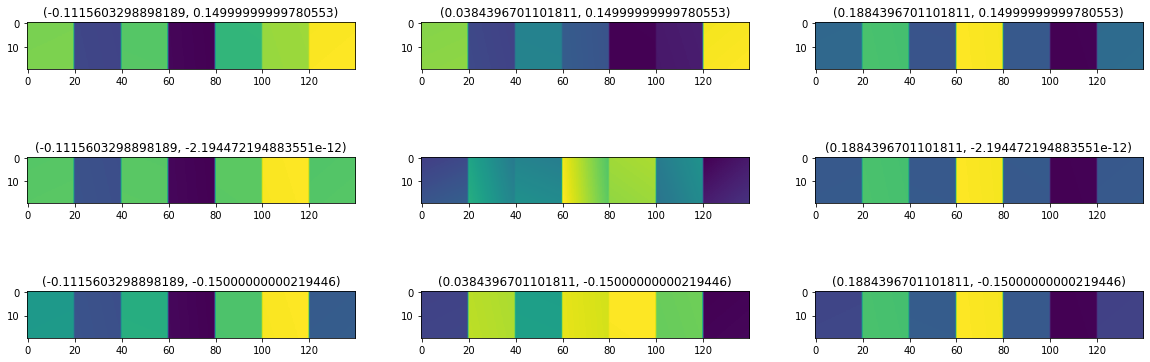

In [15]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

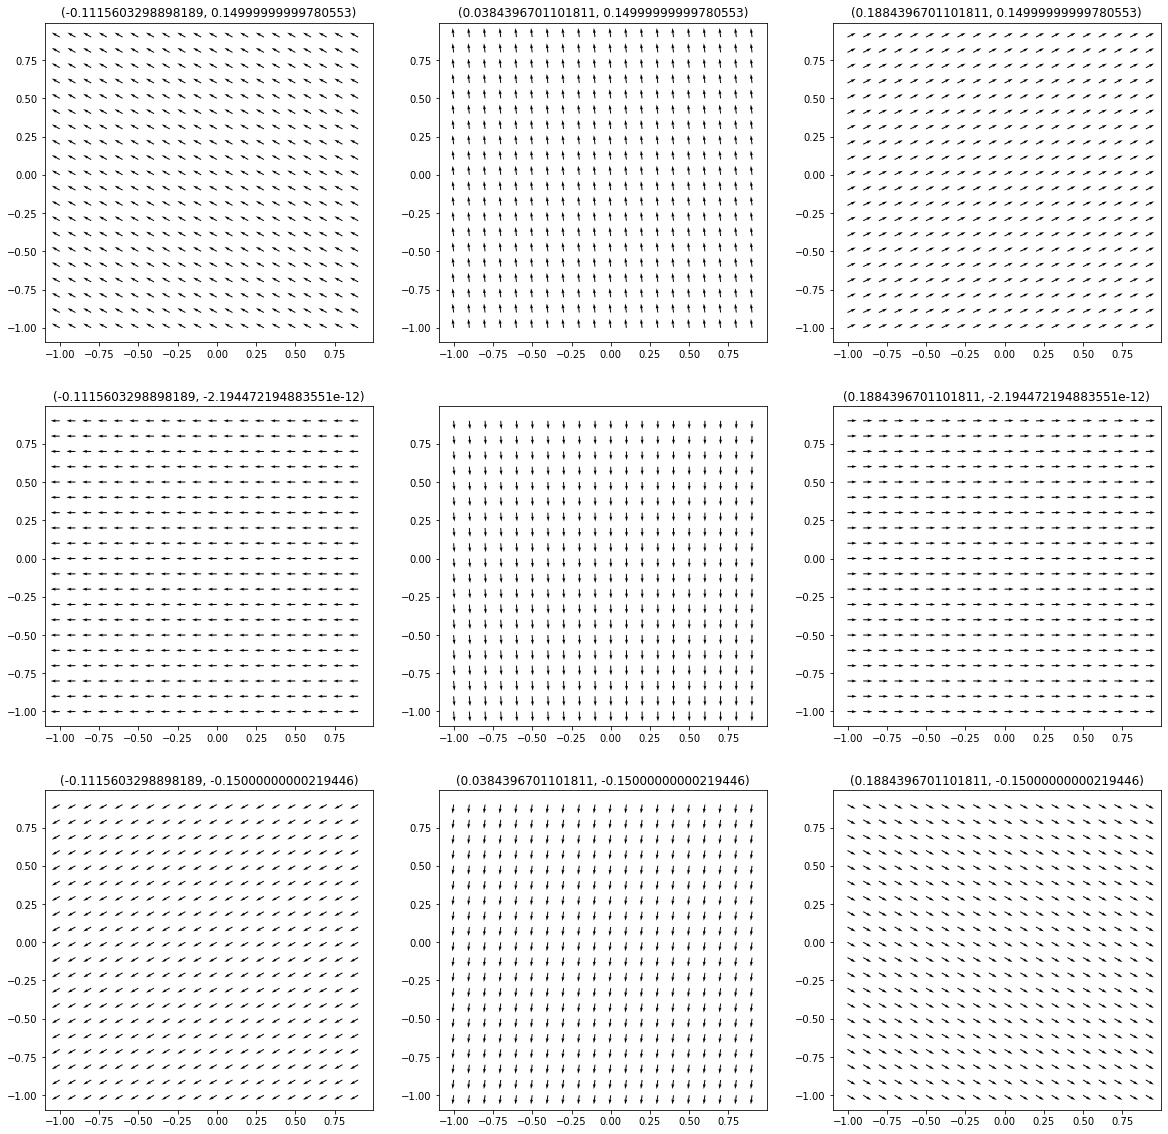

In [16]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

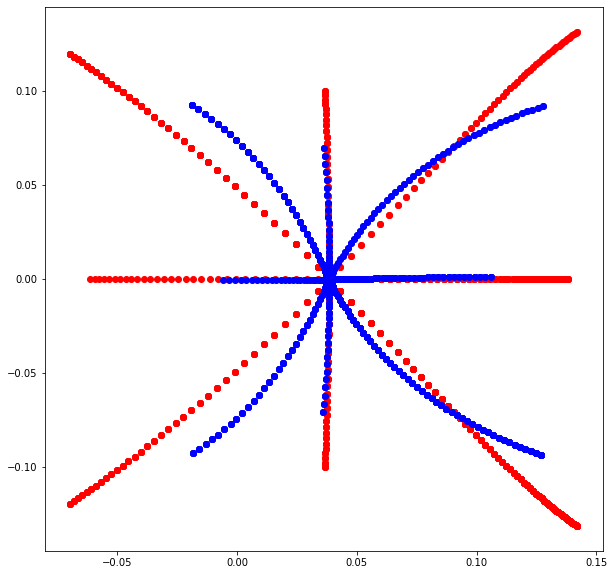

In [17]:
offline_evaluation(decoder)

## efficient-frog-413
KL = 0

Here, the surprising result is that instead of using context, the decoder mostly rely on latents to do reconstruction. This may suggest the context is not strong enough.

In [18]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/ayxhfutb/checkpoints/epoch=399-step=1000399.ckpt')

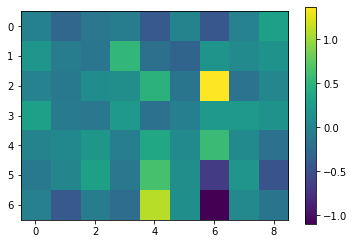

In [19]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

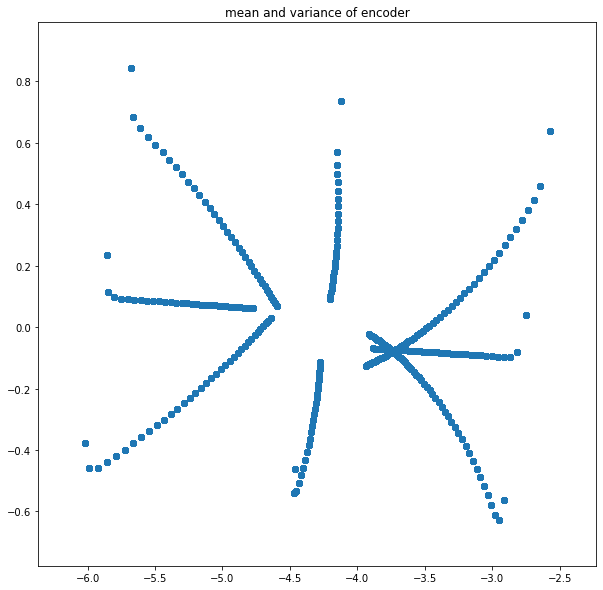

In [20]:
visualize_encoder(decoder)

{'x_min': -6.0194635, 'x_max': -2.571818, 'y_min': -0.6293975, 'y_max': 0.8454416}


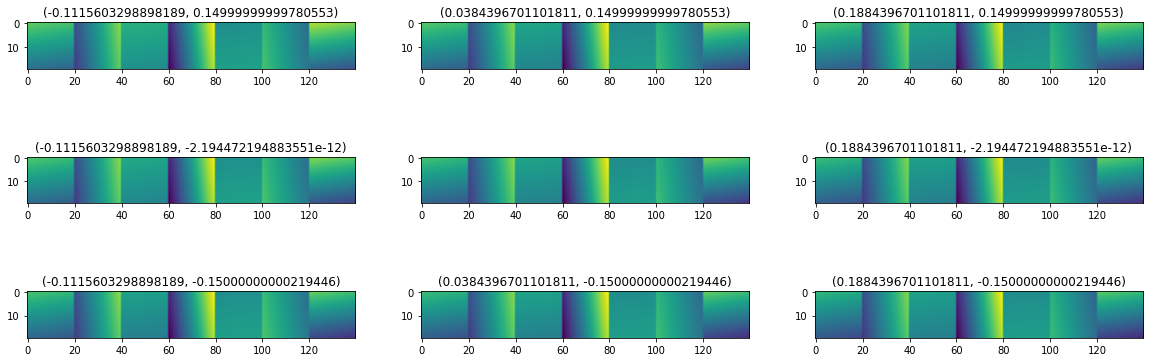

In [21]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

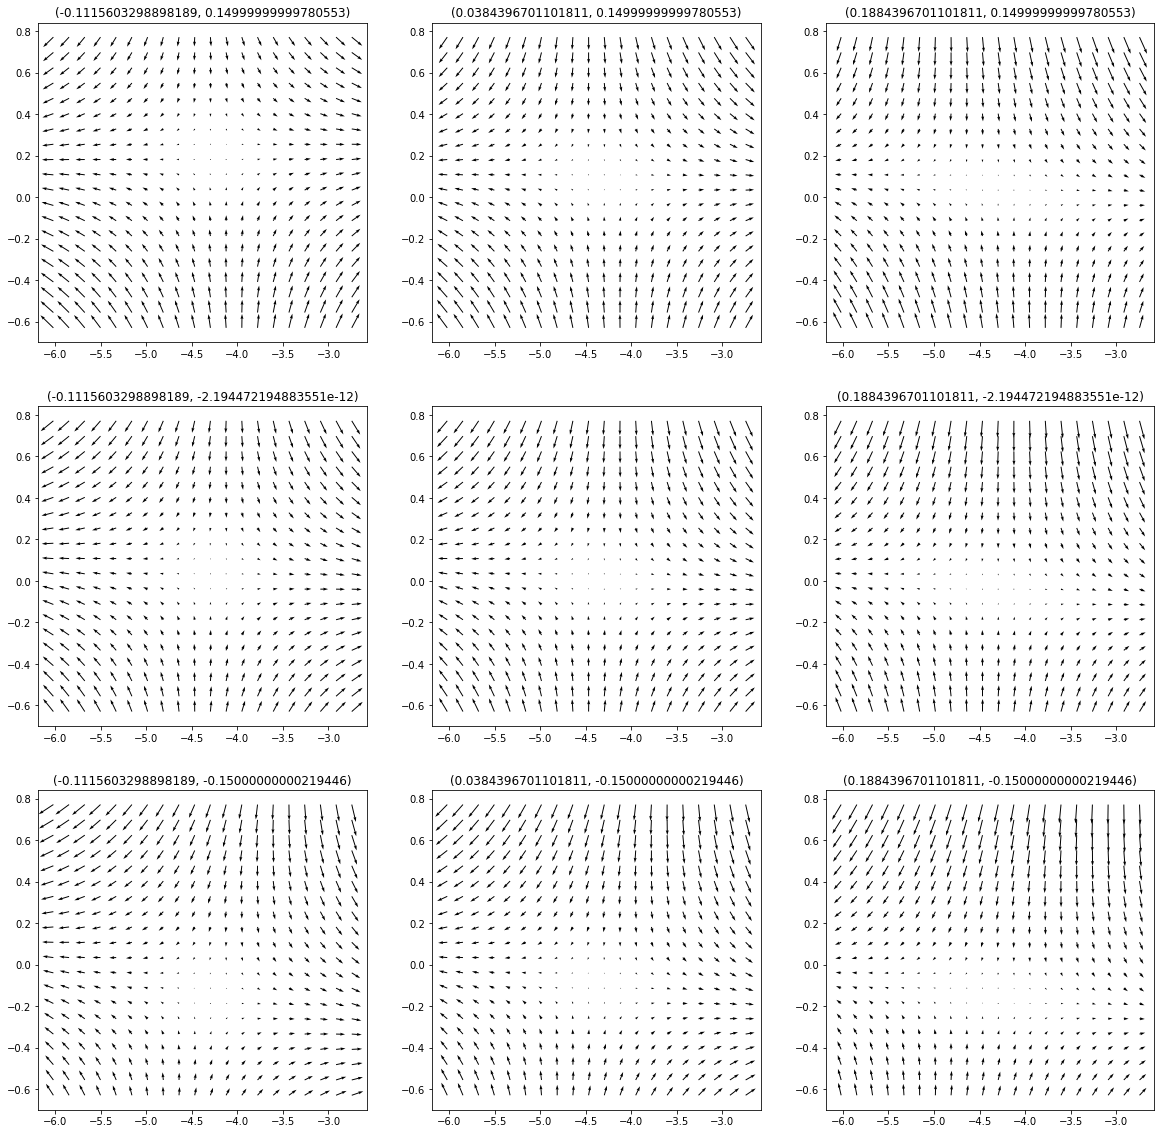

In [22]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

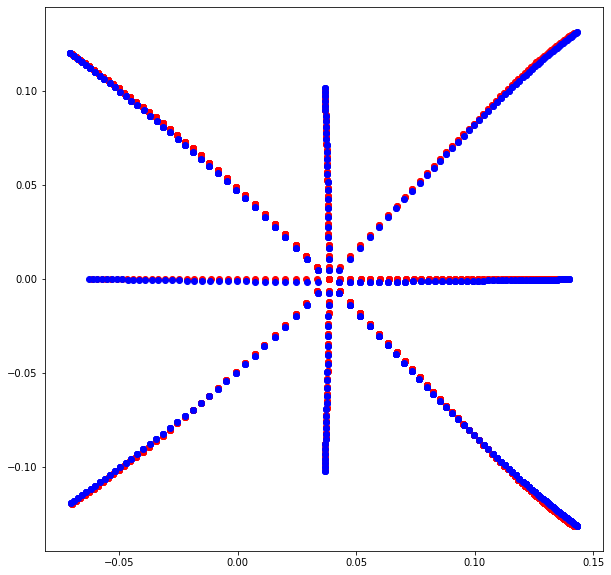

In [23]:
offline_evaluation(decoder)

## galiant-grass-415
The latents were zeroed out during training. This should essentially be supervised training with (context, action).

Important question: is the context alone sufficient to decode the action? The qualitative behavior is identical to a posterior collapsed VAE.

In [24]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/26m873lh/checkpoints/epoch=399-step=1000399.ckpt')

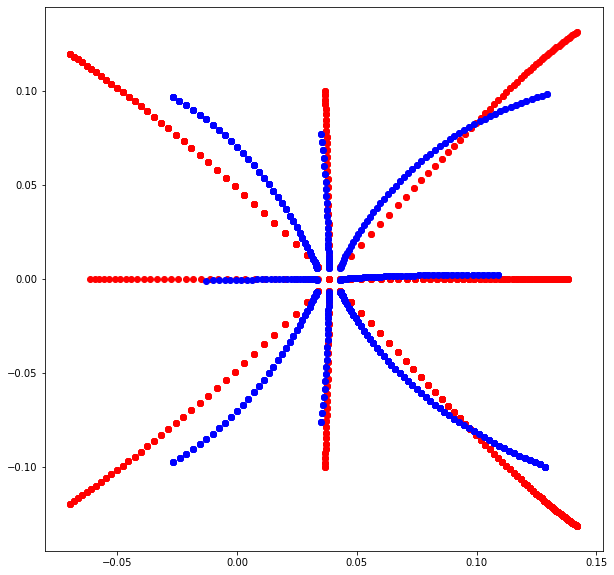

In [25]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    env.robot.set_joint_angles(episode[1]['previous_joint_angles'])
    
    ee_positions_predicted = []
    for step in episode:
        joint_action = decoder(
            latent=torch.zeros(1, 2), 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## Linear Regression

Just in case something is wrong with the zeroing out latent idea...

In [26]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])
previous_joint_angles = np.array([step['previous_joint_angles'] for epi in episodes for step in epi])

In [27]:
decoder = linear_model.LinearRegression()

In [28]:
decoder.fit(previous_joint_angles, actions_joints)

LinearRegression()

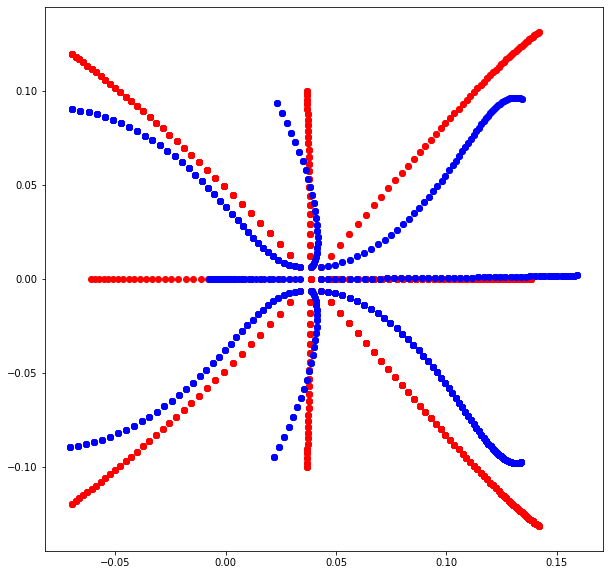

In [29]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    env.robot.set_joint_angles(episode[1]['previous_joint_angles'])
    
    ee_positions_predicted = []
    for step in episode:
        joint_action = decoder.predict(step['previous_joint_angles'][np.newaxis, :])
        obs, _, _, _ = env.step(joint_action.squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## valiant-haze-417
KL = 0

Would adding depth allow the decoder make better use of the context and start to ignore the latent?

In [30]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/30x6kxj4/checkpoints/epoch=399-step=1000399.ckpt')

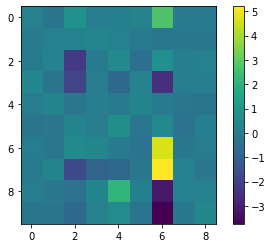

In [31]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

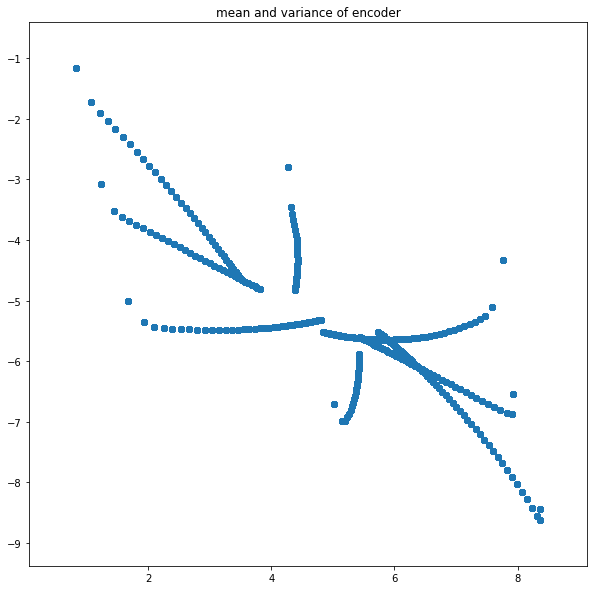

In [32]:
visualize_encoder(decoder)

{'x_min': 0.81824505, 'x_max': 8.371372, 'y_min': -8.63014, 'y_max': -1.1548231}


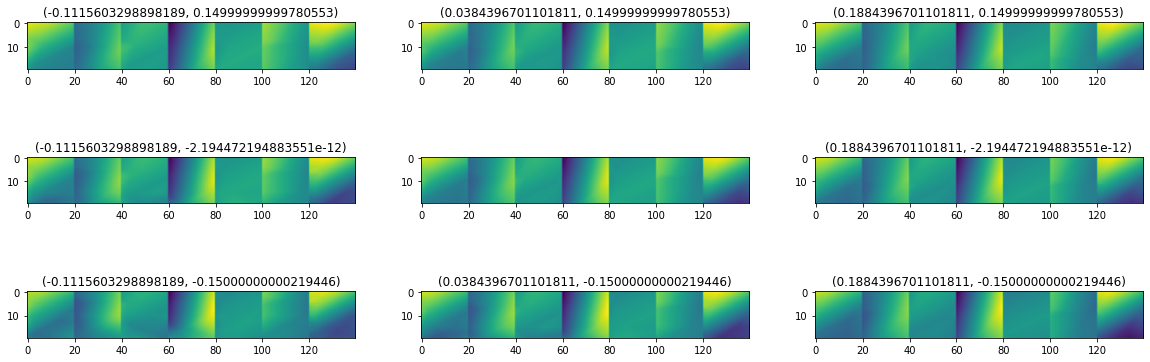

In [33]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

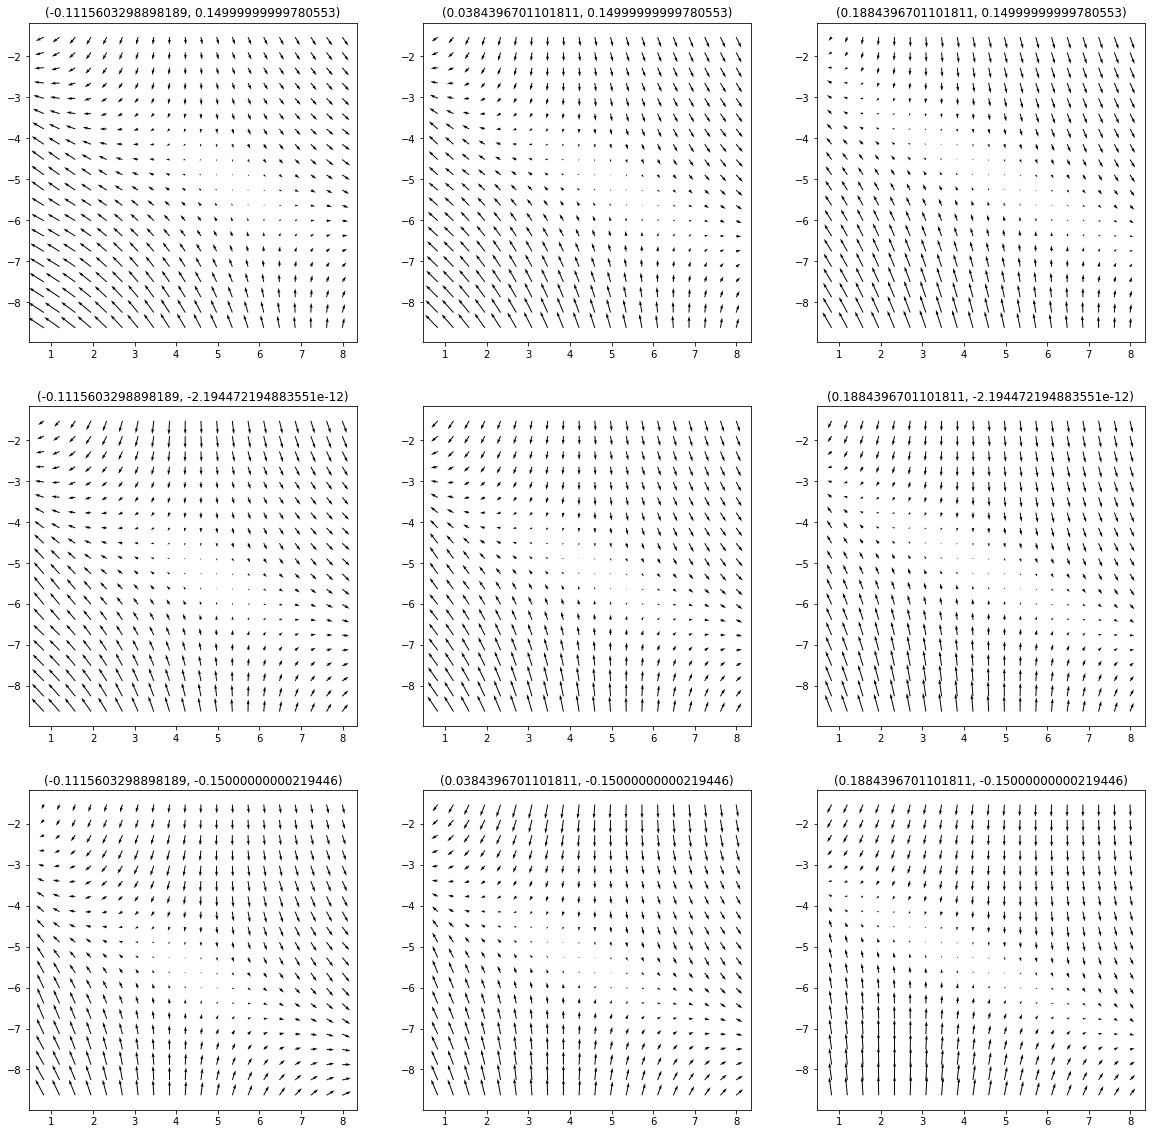

In [34]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

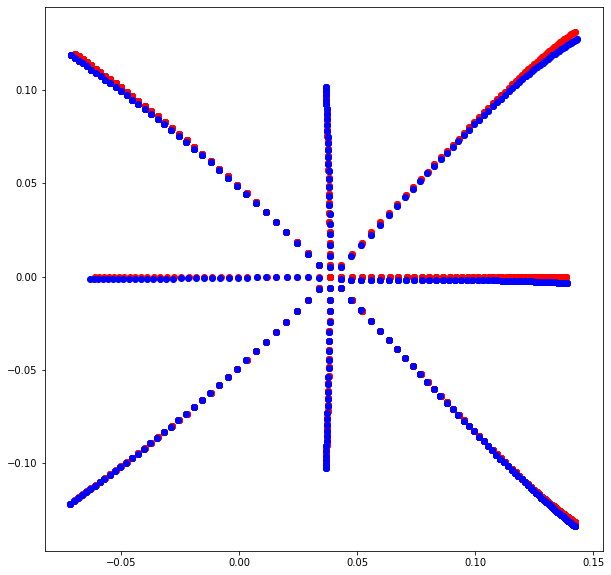

In [35]:
offline_evaluation(decoder)

## polar-aardvark-414

KL = 0.0001

If we slightly regularize the latent space, the decoder show slight context dependence.

In [36]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/i45a8pmk/checkpoints/epoch=399-step=1000399.ckpt')

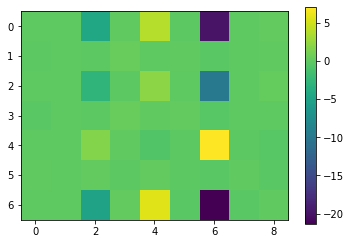

In [37]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

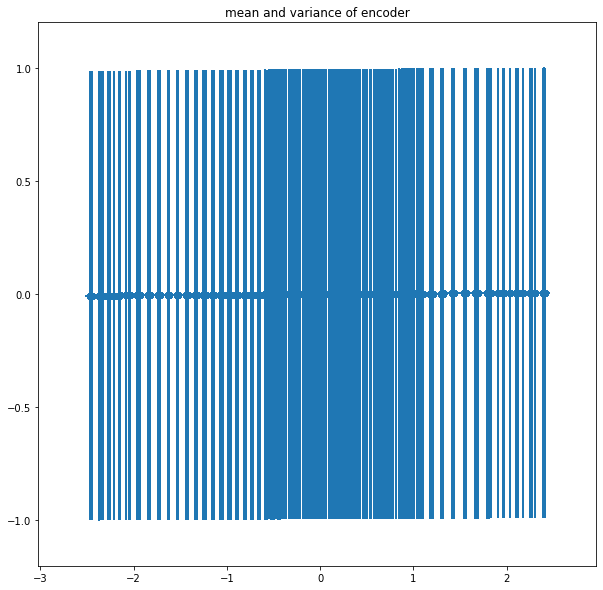

In [38]:
visualize_encoder(decoder)

{'x_min': -2.5214825, 'x_max': 2.4637442, 'y_min': -1.004406, 'y_max': 1.00417}


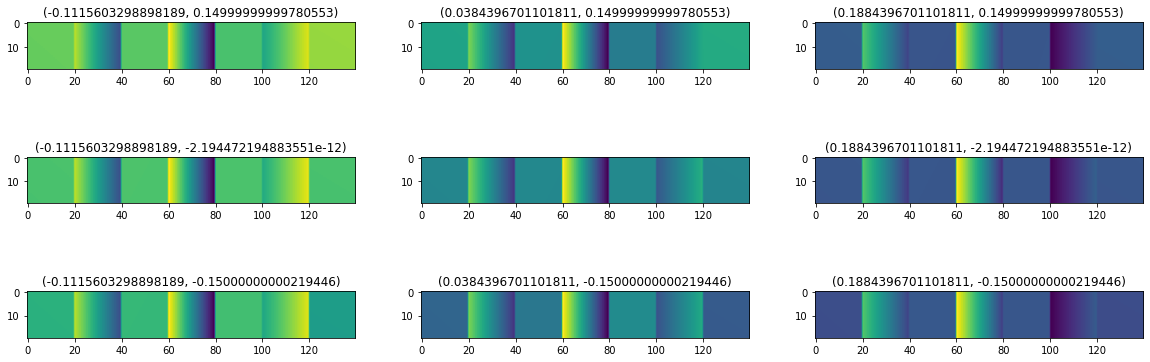

In [39]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

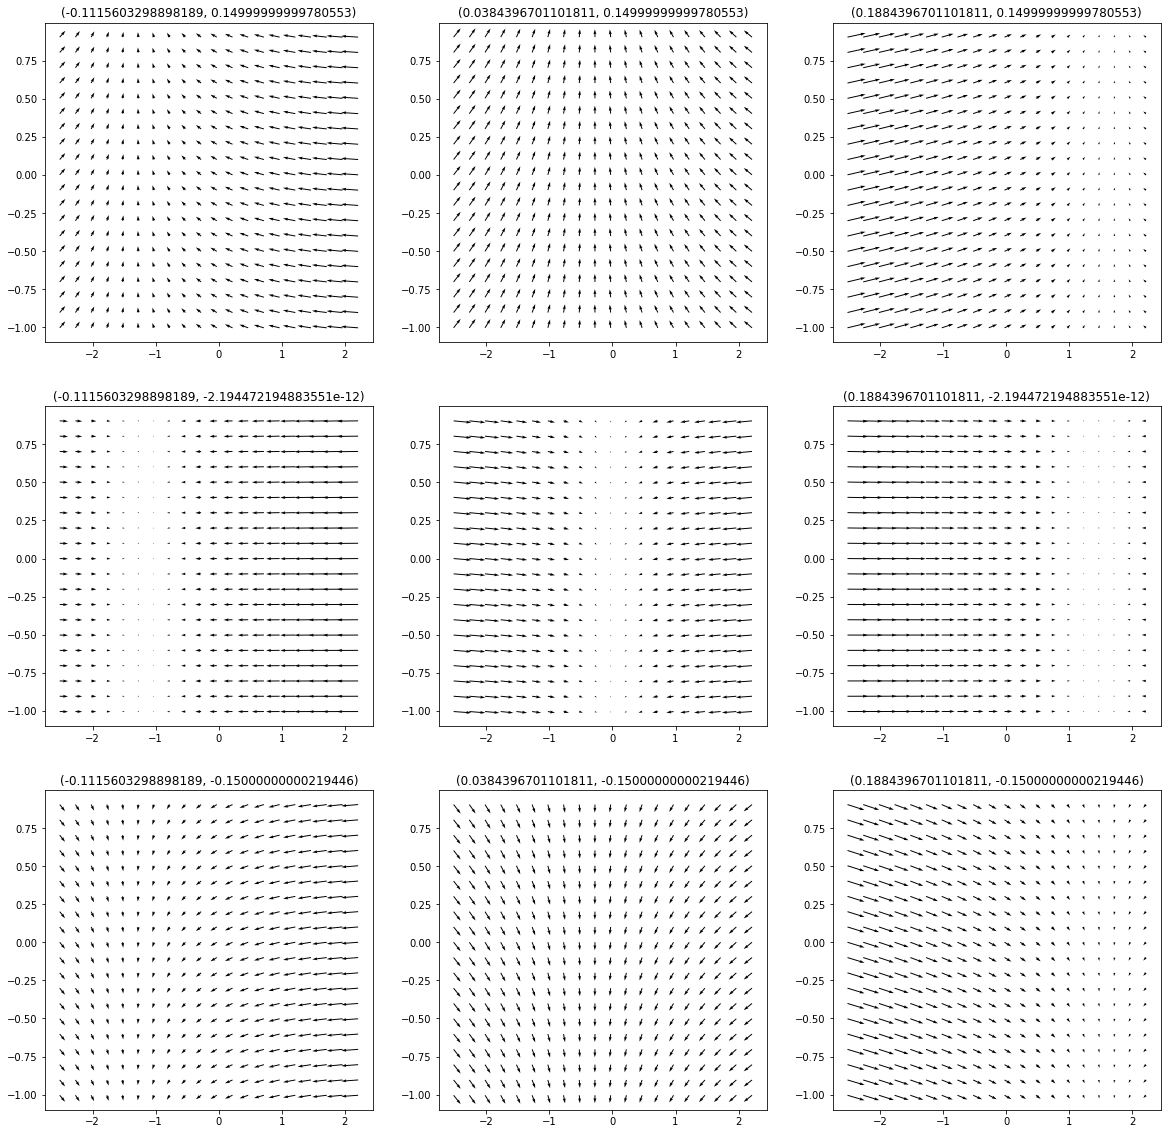

In [40]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

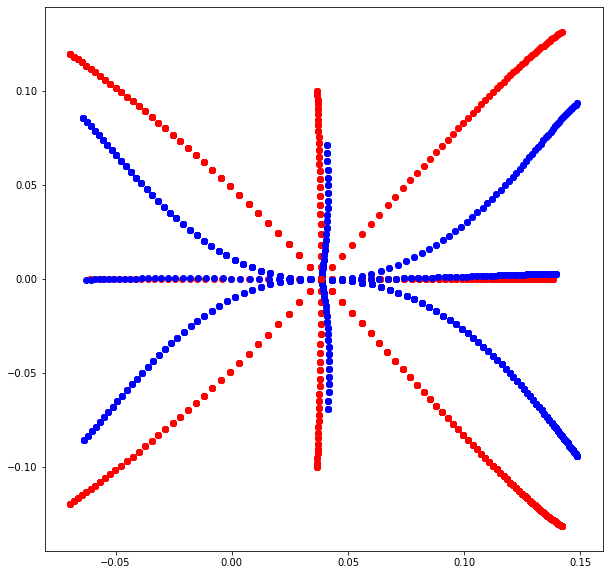

In [41]:
offline_evaluation(decoder)

## fresh-vortex-418

KL = 0.001

In [42]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/17ltye9l/checkpoints/epoch=399-step=1000399.ckpt')

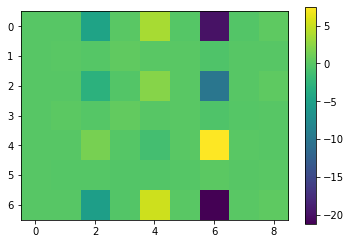

In [43]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

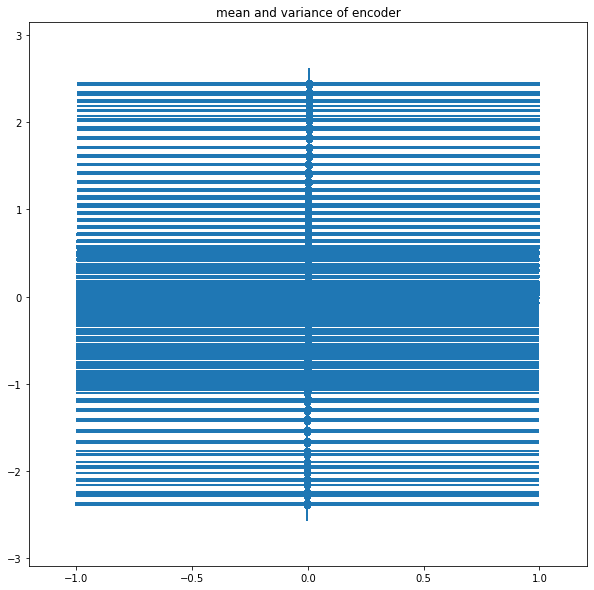

In [44]:
visualize_encoder(decoder)

{'x_min': -1.0024391, 'x_max': 1.0041397, 'y_min': -2.5673497, 'y_max': 2.6247506}


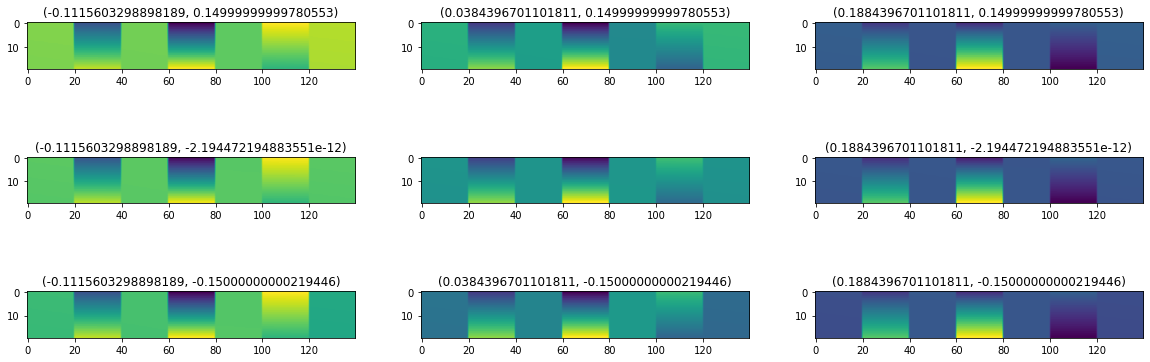

In [45]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

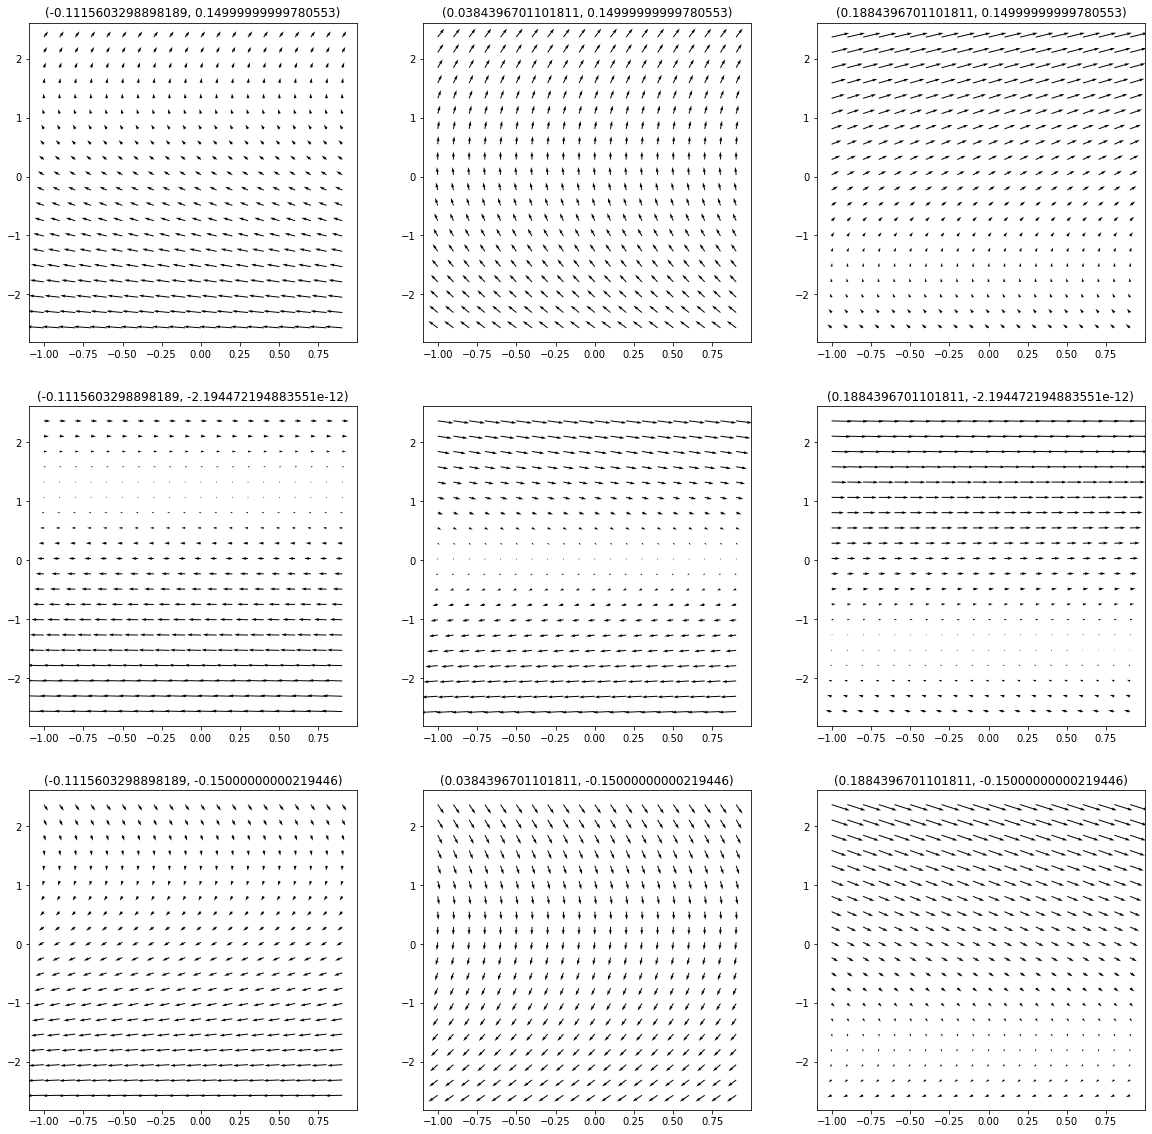

In [46]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

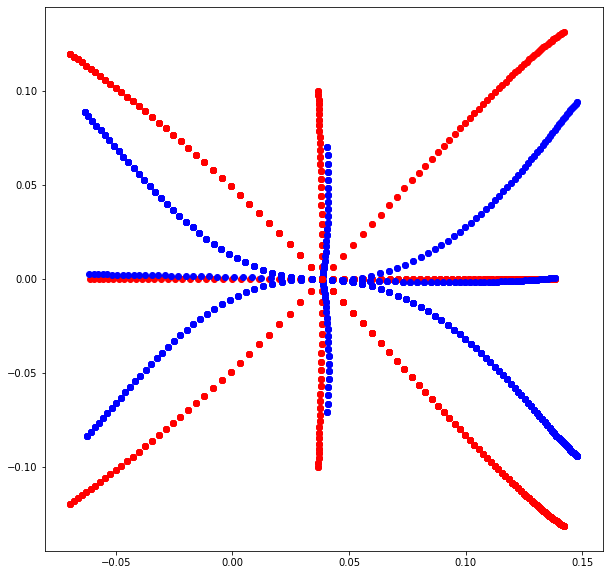

In [47]:
offline_evaluation(decoder)

## astral-wildflower-419
KL = 0.01

In [48]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/27evkbwo/checkpoints/epoch=399-step=1000399.ckpt')

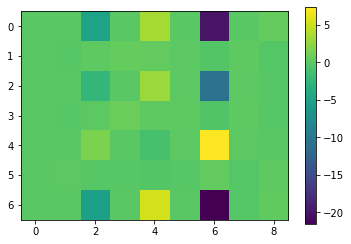

In [49]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

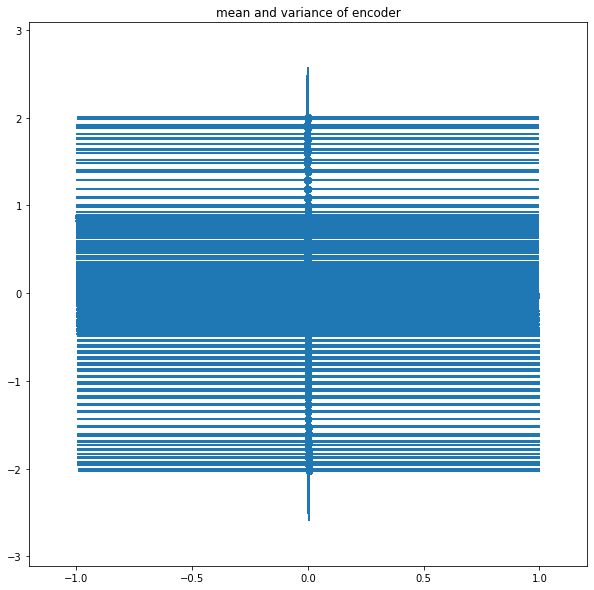

In [50]:
visualize_encoder(decoder)

{'x_min': -1.0042567, 'x_max': 1.0042493, 'y_min': -2.5907507, 'y_max': 2.5714772}


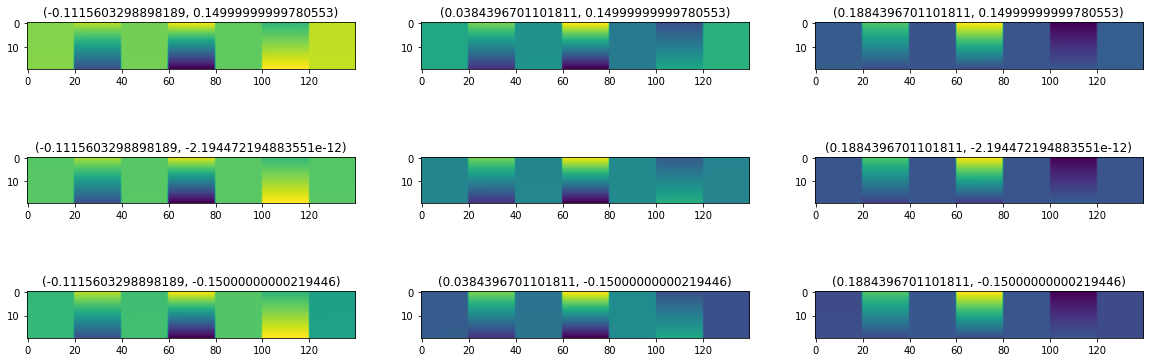

In [51]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

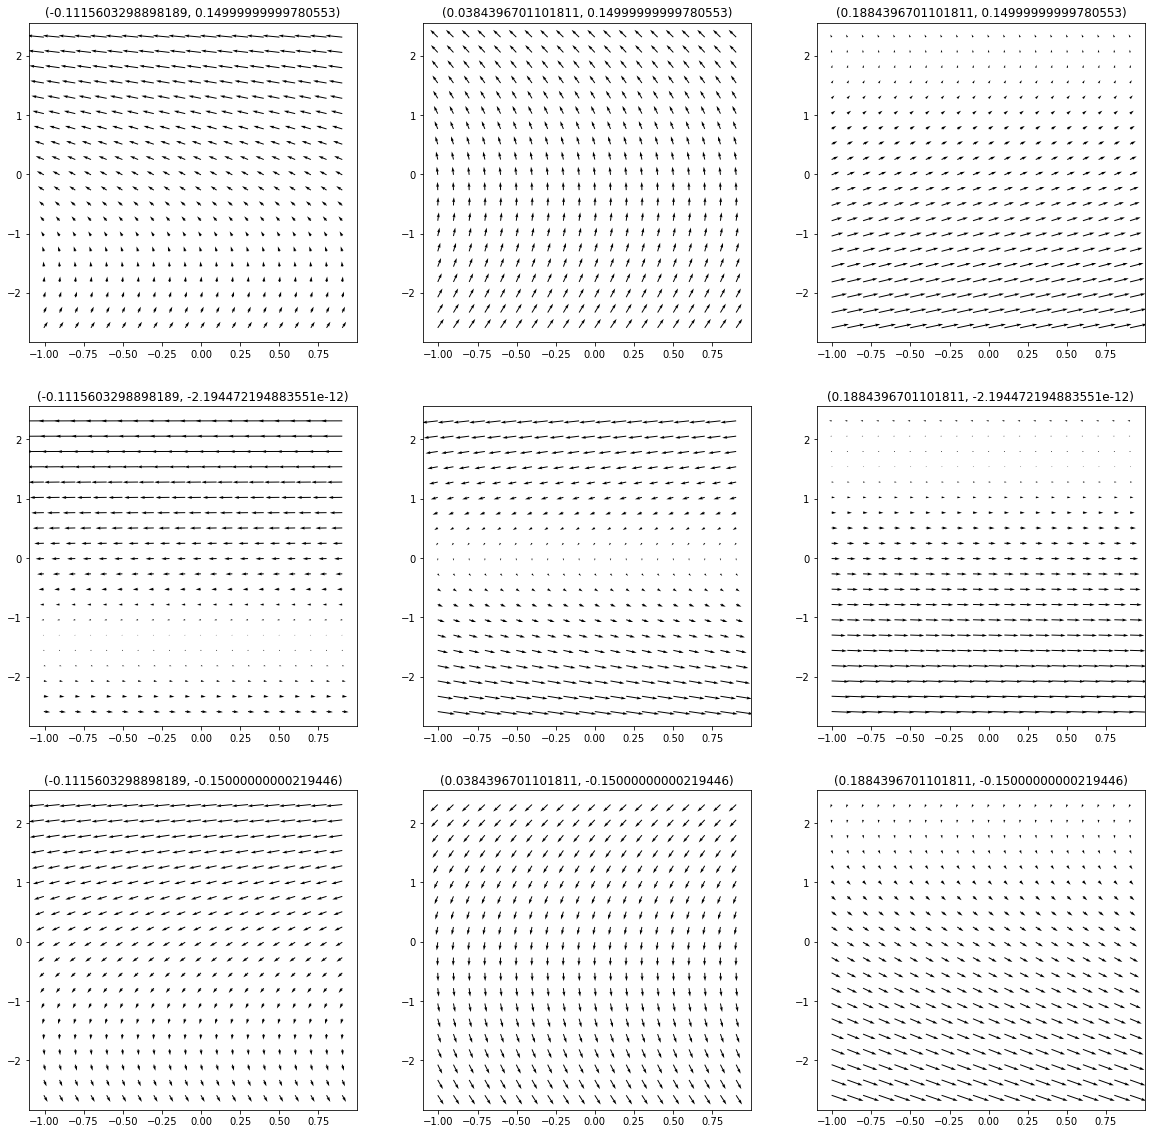

In [52]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

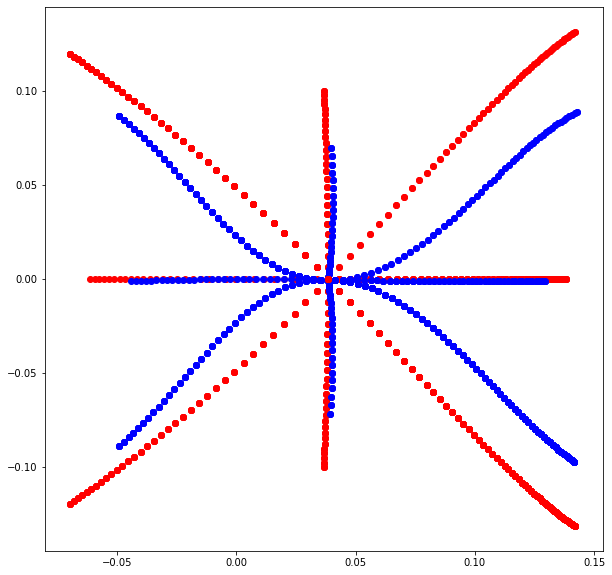

In [53]:
offline_evaluation(decoder)

## ethereal-voice-420
KL = 0.1
Here, we see latent independence again (posterior collapse).

In [54]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/ccvweala/checkpoints/epoch=399-step=1000399.ckpt')

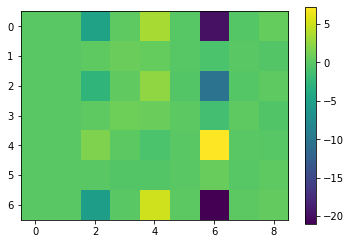

In [55]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

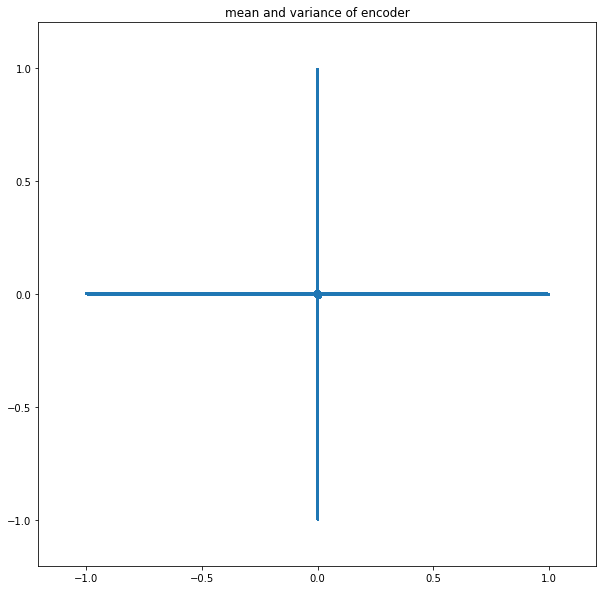

In [56]:
visualize_encoder(decoder)

{'x_min': -1.0048401, 'x_max': 1.0033724, 'y_min': -1.0025927, 'y_max': 1.002836}


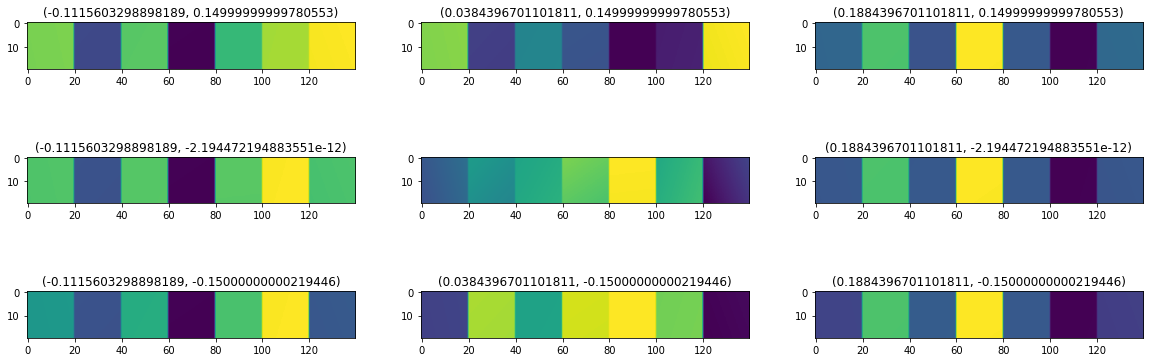

In [57]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

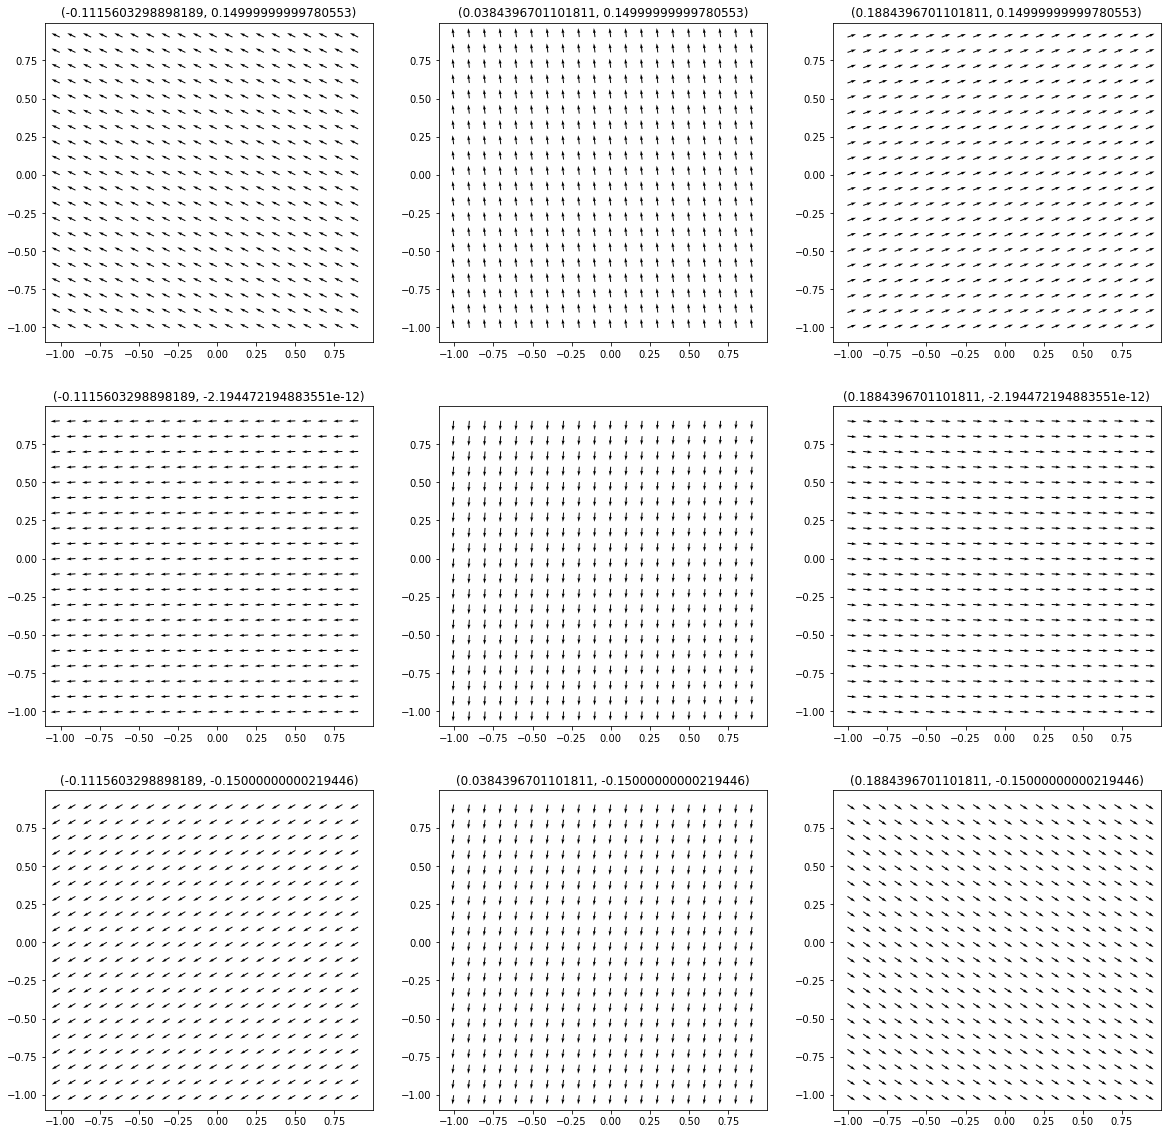

In [58]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

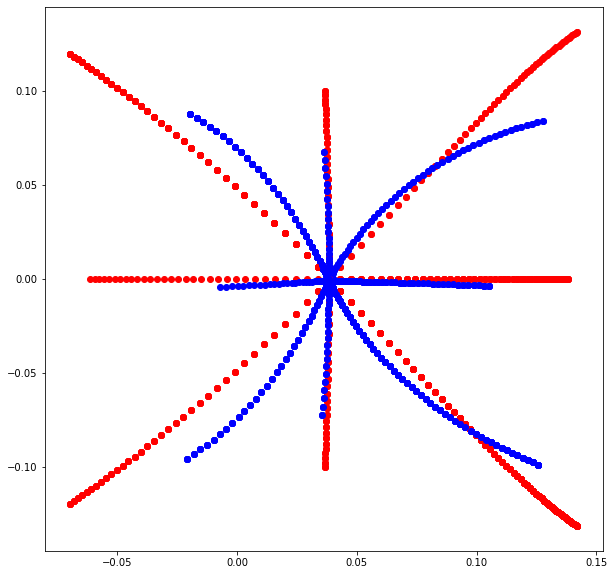

In [59]:
offline_evaluation(decoder)

## swift-planet-421
KL = 10

Beta-VAE claims when beta is greater than 1, the objective is equivalent to maximizing mutual information between x and z.

In [60]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/2s8zc7ss/checkpoints/epoch=399-step=1000399.ckpt')

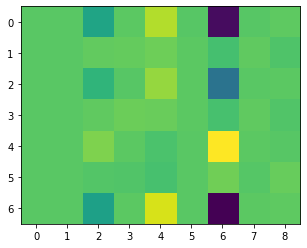

In [61]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

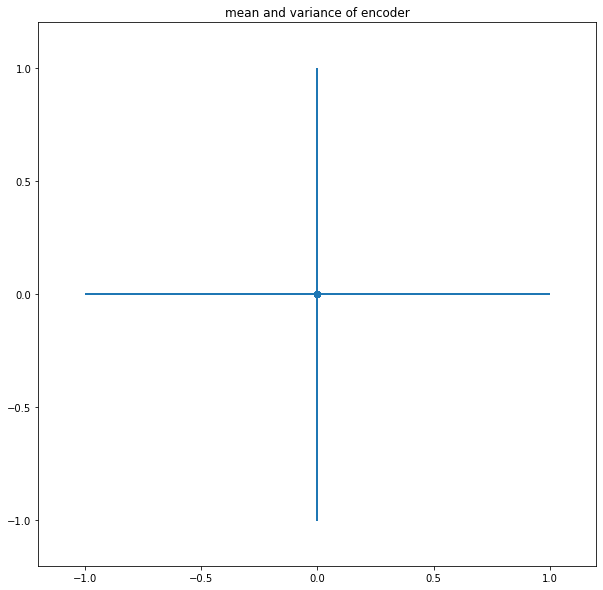

In [62]:
visualize_encoder(decoder)

{'x_min': -0.99999565, 'x_max': 1.0000157, 'y_min': -1.0000142, 'y_max': 1.0001235}


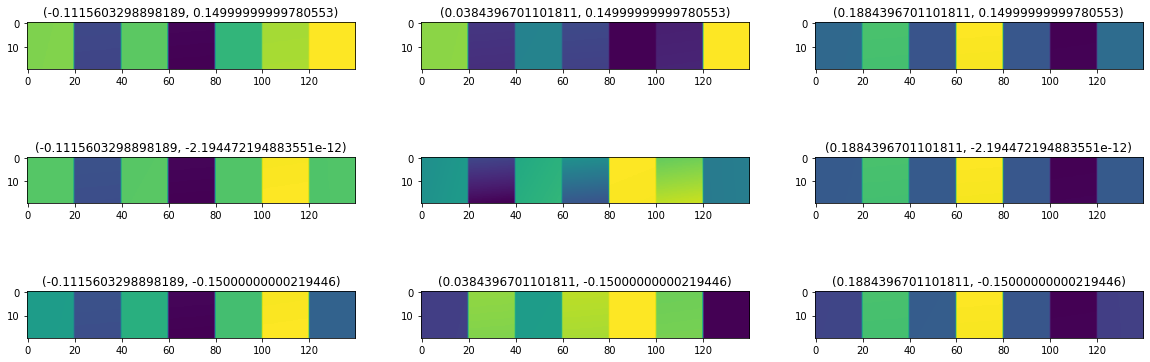

In [63]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

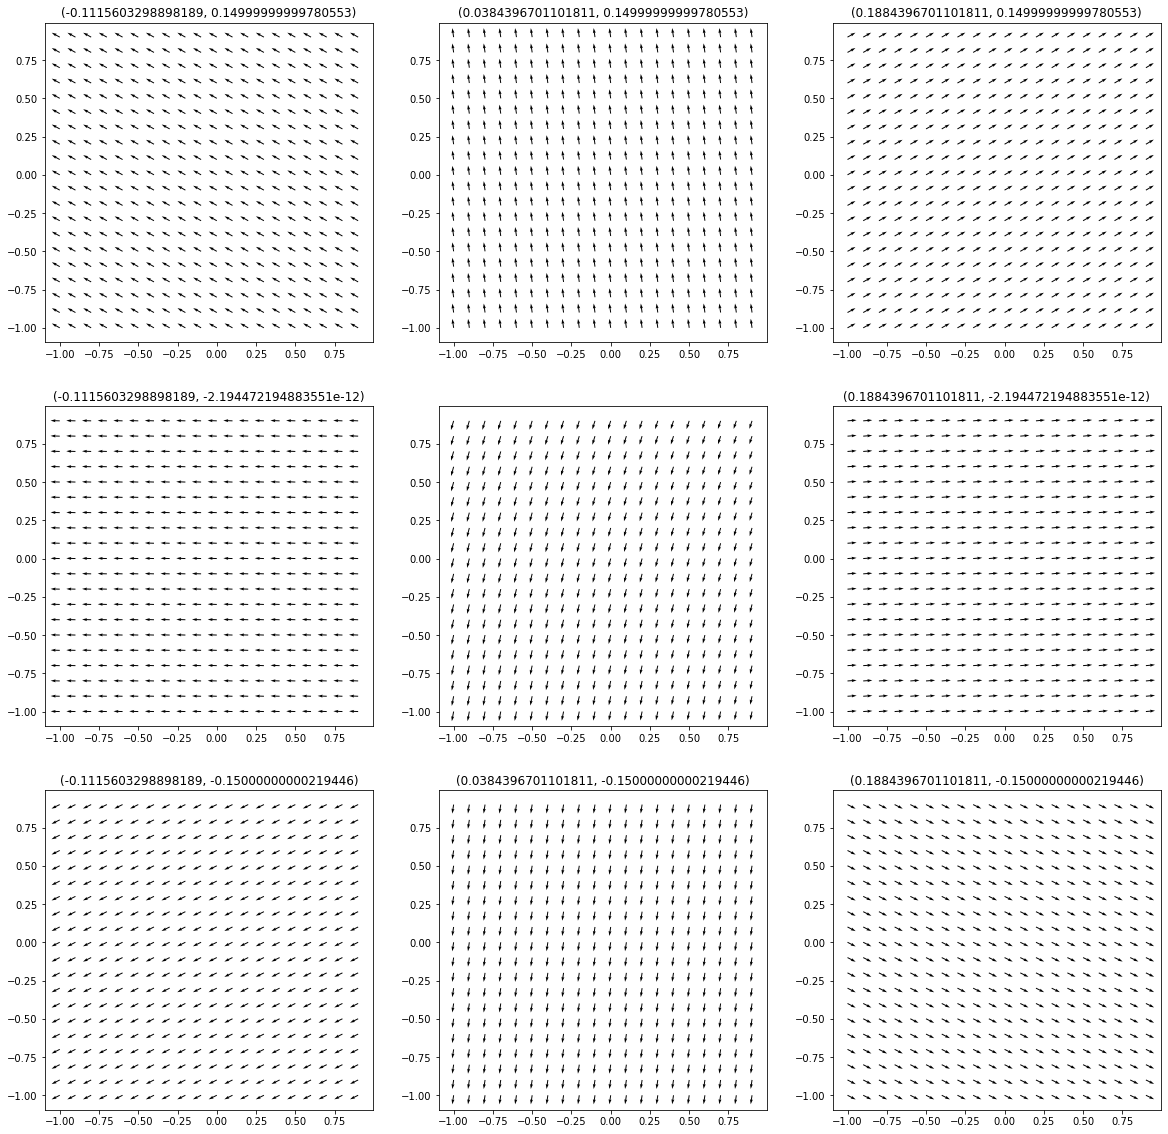

In [64]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

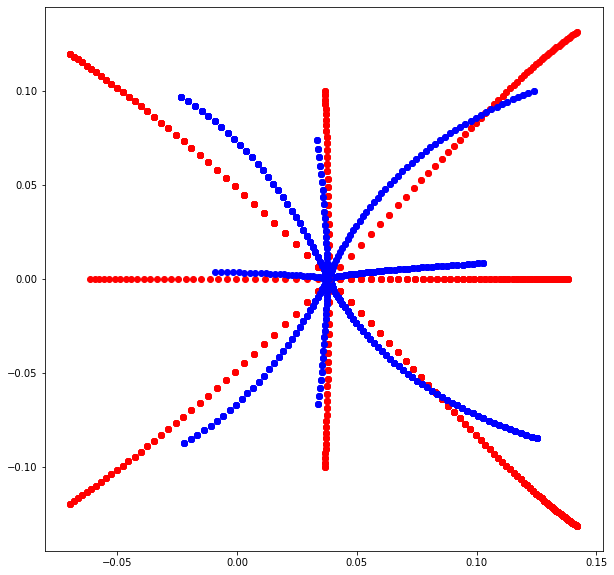

In [65]:
offline_evaluation(decoder)

## Context independence in decoder field

This happens when KL = 0.

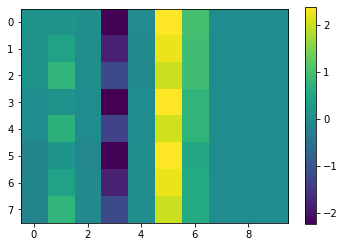

In [66]:
plt.imshow(joint_angles_at_goals)
plt.colorbar()

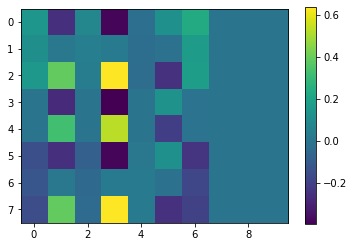

In [67]:
plt.imshow(joint_angles_at_goals - neutral_joint_angles)
plt.colorbar()

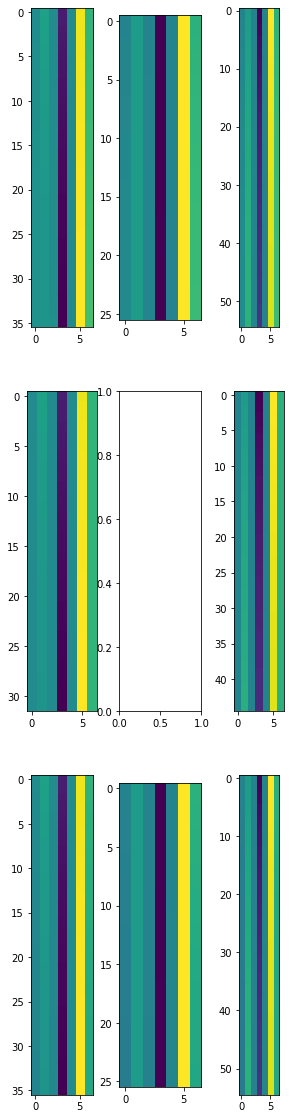

In [68]:
# How much does the joint angles context change in each episode?

fig, axs = plt.subplots(3, 3, figsize=(5, 20))

for i, goal in enumerate(goals):
    if i >= 4:
        i += 1 # offset for visualization
        
    for j, episode in enumerate(episodes):
        if np.all(episode[0]['previous_observation']['desired_goal'] == goal):
            break

    axs[i // 3, i % 3].imshow(np.stack([step['previous_joint_angles'] for step in episode]))

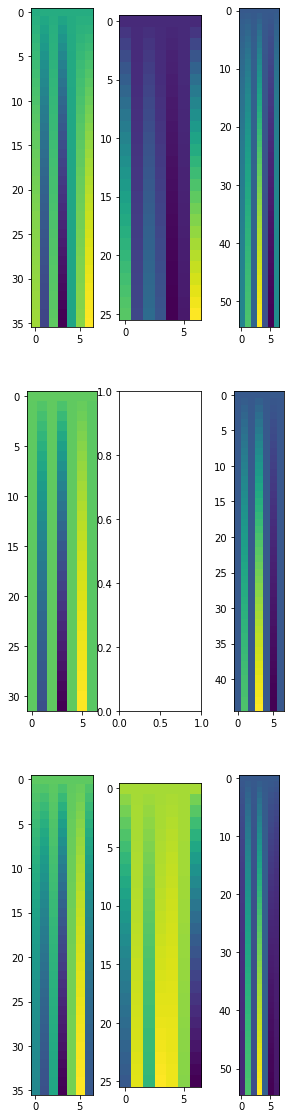

In [69]:
# Subtract the neutral joint angles and the change is more obvious

fig, axs = plt.subplots(3, 3, figsize=(5, 20))

for i, goal in enumerate(goals):
    if i >= 4:
        i += 1 # offset for visualization
        
    for j, episode in enumerate(episodes):
        if np.all(episode[0]['previous_observation']['desired_goal'] == goal):
            break
    
    axs[i // 3, i % 3].imshow(np.stack([step['previous_joint_angles'] - neutral_joint_angles[:7] for step in episode]))

## confused-firefly-422

KL = 0

Subtract neutral joint angles from context and see if the decoder starts to utilize context with no variational constraints

In [70]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/vi4sg6ws/checkpoints/epoch=399-step=1000399.ckpt')

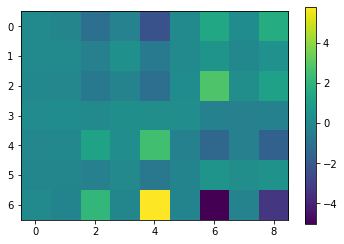

In [71]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

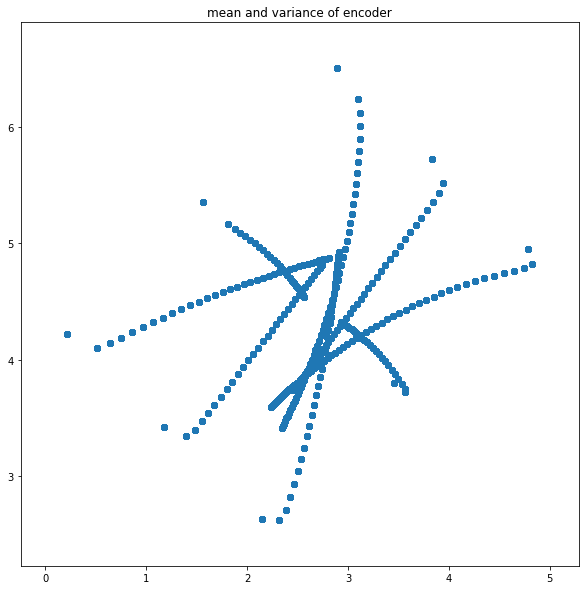

In [72]:
visualize_encoder(decoder)

{'x_min': 0.21443348, 'x_max': 4.8258305, 'y_min': 2.6192281, 'y_max': 6.511679}


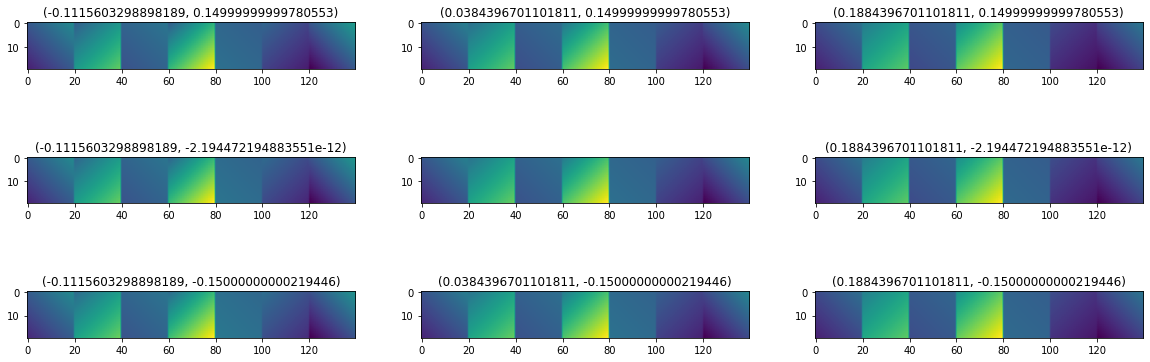

In [73]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds, subtract_neutral_from_context=True)

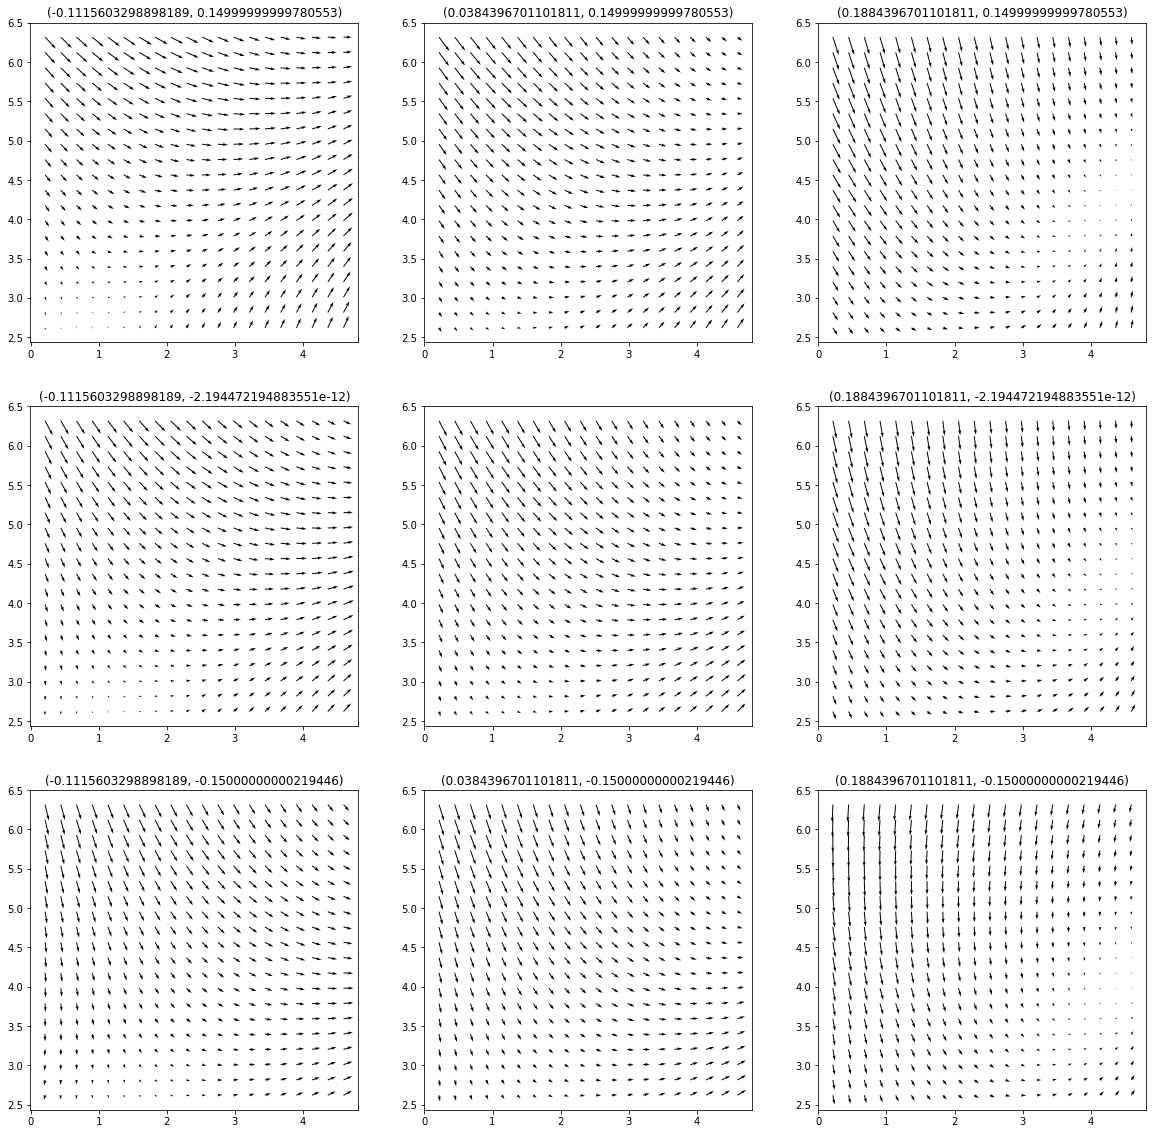

In [74]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds, subtract_neutral_from_context=True)

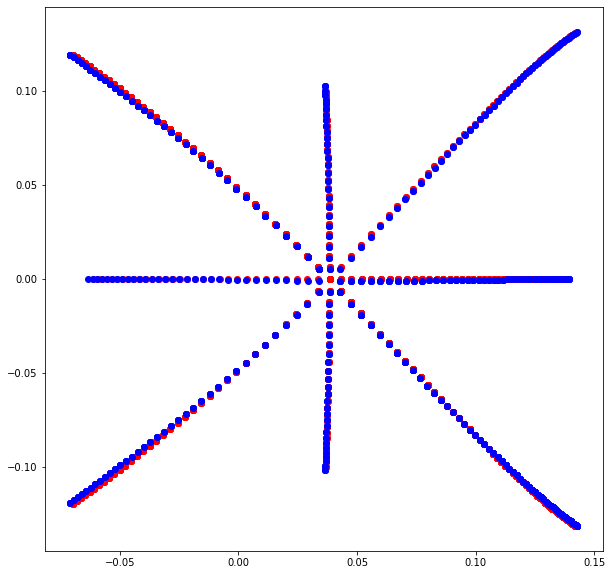

In [75]:
offline_evaluation(decoder, subtract_neutral_from_context=True)

## chocolate-rain-423

KL = 0 

subtract neutral, add depth

In [76]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/3nkox5y1/checkpoints/epoch=399-step=1000399.ckpt')

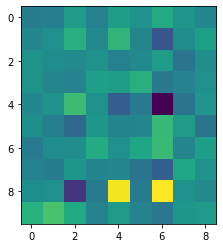

In [77]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

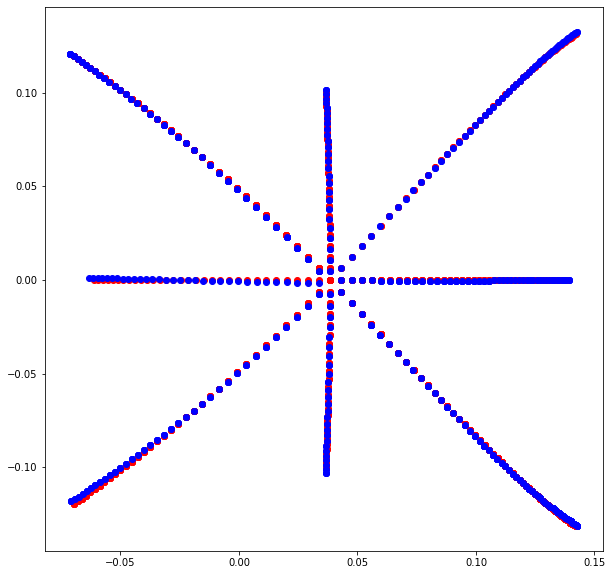

In [78]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    
    ee_positions_predicted = []
    for step in episode:
        z = decoder.encoder(
            torch.cat((
                torch.tensor(step['action_joints'], dtype=torch.float), 
                torch.tensor(step['previous_joint_angles'] - neutral_joint_angles[:7], dtype=torch.float)))).reshape(1, -1)
        z = decoder.fc_mu(z)
        joint_action = decoder(
            latent=z, 
            context=torch.tensor(step['previous_joint_angles'] - neutral_joint_angles[:7], dtype=torch.float).reshape(1, -1))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()